In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

prod = "[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10][CH2:9][NH:8][CH2:13][CH2:12]1"
reac = "c1ccc(C[N:8]2[CH2:9][CH2:10][N:11]([S:14](=[O:15])(=[O:16])[CH3:17])[CH2:12][CH2:13]2)cc1"

template = "[C]-[NH;D2;+0]-[C]>>[C]-[N;H0;D3;+0](-[C])-C-c1:c:c:c:c:c:1"

s1=[Chem.MolFromSmiles(x) for x in ('NC','NCC')]
s2=[Chem.MolFromSmiles(x) for x in ('OC=O','OC(=O)C')]
rxn = AllChem.ReactionFromSmarts('[O:2]=[C:1][OH].[N:3]>>[O:2]=[C:1][N:3]')
r = AllChem.EnumerateLibraryFromReaction(rxn,[s2,s1])
[Chem.MolToSmiles(x[0]) for x in list(r)]

['CNC=O', 'CCNC=O', 'CNC(C)=O', 'CCNC(C)=O']

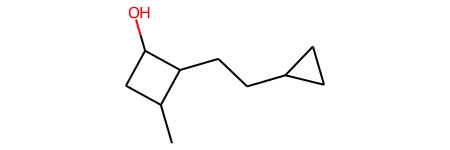

In [22]:
m = Chem.MolFromSmiles('CC1CC(O)C1CCC1CC1')
bs = [4]
nm = Chem.FragmentOnBonds(m, bs, addDummies=False)
bs = [3]
nm2 = Chem.FragmentOnBonds(m, bs, addDummies=False)
smi = Chem.MolToSmiles(nm)
m

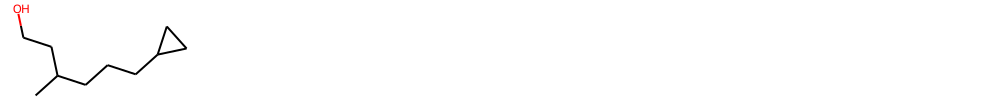

In [26]:
from rdkit.Chem import AllChem, Draw
mol_list = Chem.GetMolFrags(nm, asMols=True)
imgs = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(200,100))
imgs